In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [2]:
# Load the scaled datasets
fma_small = pd.read_csv('../data/fma_small_scaled.csv')
fma_medium = pd.read_csv('../data/fma_medium_scaled.csv')
gtzan = pd.read_csv('../data/gtzan_scaled.csv')
instrumental = pd.read_csv('../data/instrumental_scaled.csv')

print("Dataset shapes:")
print(f"FMA Small: {fma_small.shape}")
print(f"FMA Medium: {fma_medium.shape}")
print(f"GTZAN: {gtzan.shape}")
print(f"Instrumental: {instrumental.shape}")

Dataset shapes:
FMA Small: (4718, 73)
FMA Medium: (14548, 73)
GTZAN: (688, 73)
Instrumental: (304, 73)


In [3]:
# Function to prepare dataset
def prepare_dataset(df):
    X = df.drop(['label', 'label_encoded'], axis=1)
    y = df['label_encoded']
    return X, y

# Prepare all datasets
X_gtzan, y_gtzan = prepare_dataset(gtzan)
X_fma_small, y_fma_small = prepare_dataset(fma_small)
X_fma_medium, y_fma_medium = prepare_dataset(fma_medium)
X_instrumental, y_instrumental = prepare_dataset(instrumental)

print(f"\nGTZAN - Features: {X_gtzan.shape[1]}, Samples: {X_gtzan.shape[0]}")
print(f"FMA Small - Features: {X_fma_small.shape[1]}, Samples: {X_fma_small.shape[0]}")
print(f"FMA Medium - Features: {X_fma_medium.shape[1]}, Samples: {X_fma_medium.shape[0]}")
print(f"Instrumental - Features: {X_instrumental.shape[1]}, Samples: {X_instrumental.shape[0]}")


GTZAN - Features: 71, Samples: 688
FMA Small - Features: 71, Samples: 4718
FMA Medium - Features: 71, Samples: 14548
Instrumental - Features: 71, Samples: 304


In [4]:
# Apply PCA with all components on GTZAN dataset
pca_full = PCA(n_components=min(X_gtzan.shape))
pca_full.fit(X_gtzan)

# Get explained variance
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("Explained Variance by First 10 Components:")
for i in range(min(10, len(explained_variance))):
    print(f"PC{i+1}: {explained_variance[i]:.4f} (Cumulative: {cumulative_variance[i]:.4f})")

Explained Variance by First 10 Components:
PC1: 0.2173 (Cumulative: 0.2173)
PC2: 0.1228 (Cumulative: 0.3400)
PC3: 0.1030 (Cumulative: 0.4430)
PC4: 0.0586 (Cumulative: 0.5017)
PC5: 0.0476 (Cumulative: 0.5492)
PC6: 0.0441 (Cumulative: 0.5933)
PC7: 0.0297 (Cumulative: 0.6230)
PC8: 0.0278 (Cumulative: 0.6507)
PC9: 0.0239 (Cumulative: 0.6746)
PC10: 0.0217 (Cumulative: 0.6963)


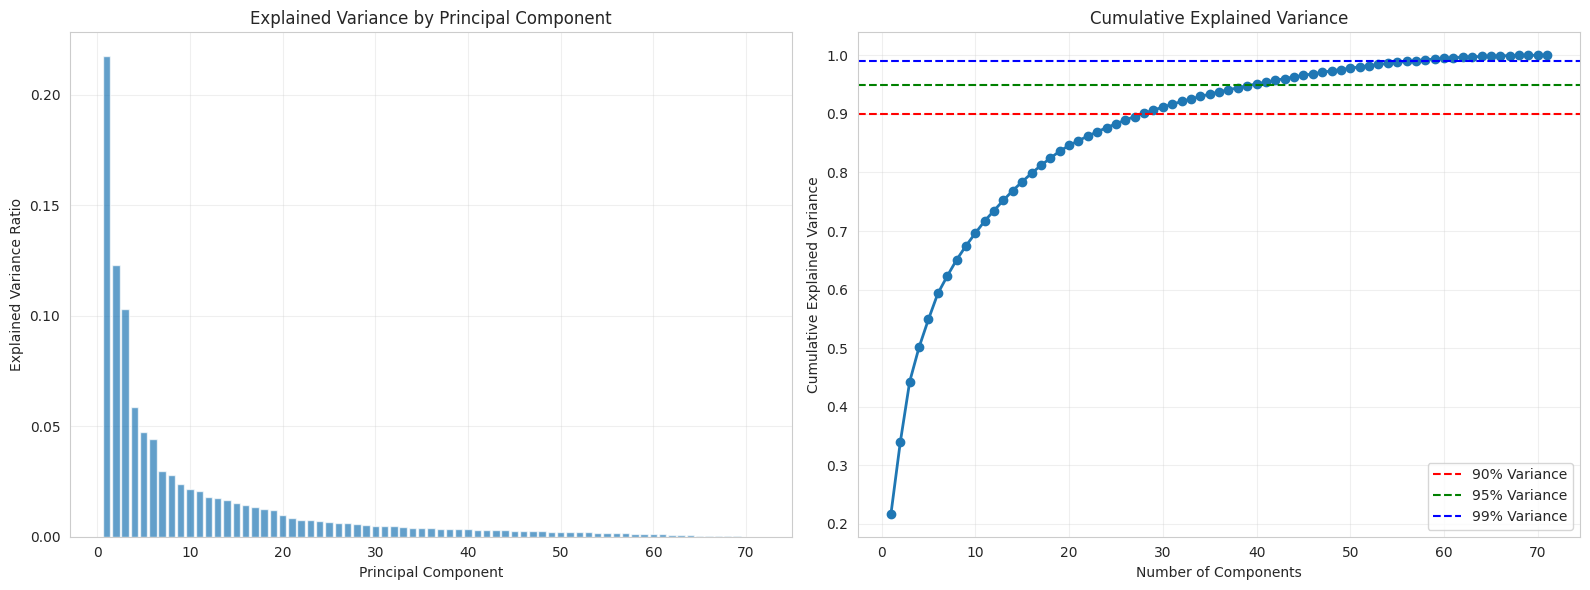

Components needed for 90% variance: 28
Components needed for 95% variance: 40
Components needed for 99% variance: 57


In [5]:
# Visualize explained variance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Individual explained variance
axes[0].bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Explained Variance by Principal Component')
axes[0].grid(True, alpha=0.3)

# Cumulative explained variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linewidth=2)
axes[1].axhline(y=0.90, color='r', linestyle='--', label='90% Variance')
axes[1].axhline(y=0.95, color='g', linestyle='--', label='95% Variance')
axes[1].axhline(y=0.99, color='b', linestyle='--', label='99% Variance')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find number of components for different variance thresholds
for threshold in [0.90, 0.95, 0.99]:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    print(f"Components needed for {threshold*100:.0f}% variance: {n_components}")

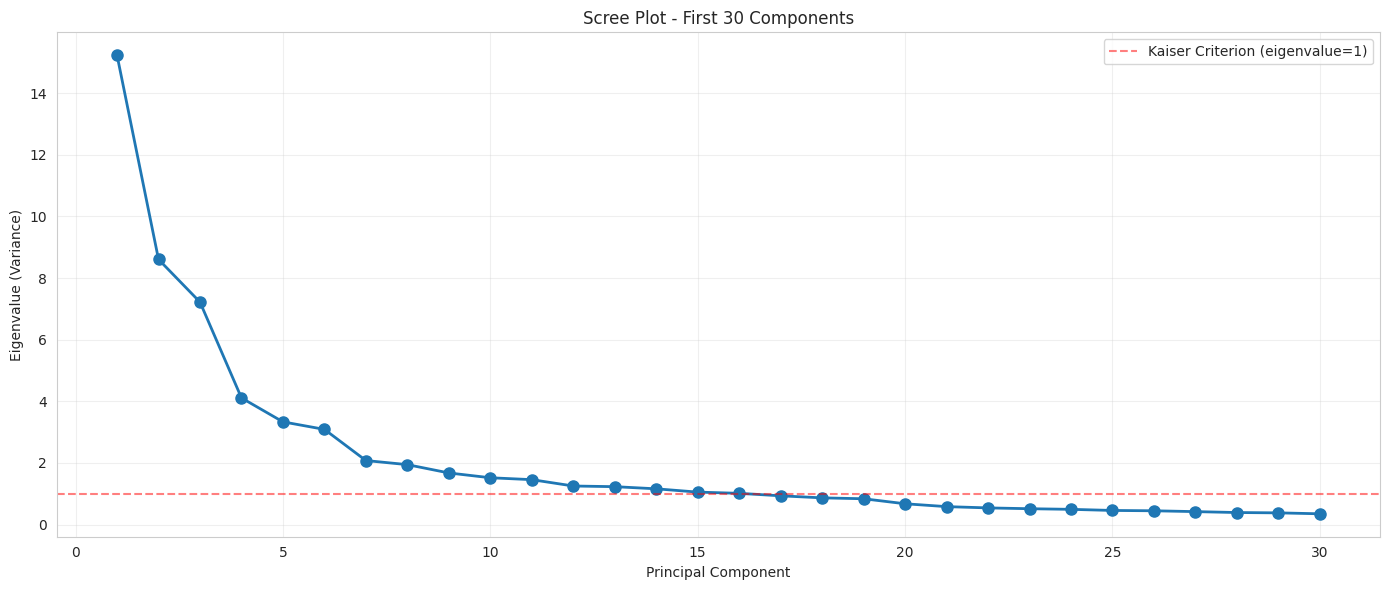


Number of components with eigenvalue > 1 (Kaiser criterion): 16


In [6]:
# Create scree plot
plt.figure(figsize=(14, 6))

# Plot eigenvalues
eigenvalues = pca_full.explained_variance_
plt.plot(range(1, min(31, len(eigenvalues) + 1)), eigenvalues[:30], marker='o', linewidth=2, markersize=8)
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue (Variance)')
plt.title('Scree Plot - First 30 Components')
plt.grid(True, alpha=0.3)

# Add reference line at eigenvalue = 1 (Kaiser criterion)
plt.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Kaiser Criterion (eigenvalue=1)')
plt.legend()

plt.tight_layout()
plt.show()

# Count components with eigenvalue > 1
n_kaiser = np.sum(eigenvalues > 1)
print(f"\nNumber of components with eigenvalue > 1 (Kaiser criterion): {n_kaiser}")

In [7]:
# Test different numbers of components
n_components_list = [2, 3, 5, 10, 15, 20, 25, 30, 40, 50]
results = []

print("Testing different numbers of components...\n")

for n_comp in n_components_list:
    if n_comp > X_gtzan.shape[1]:
        continue
    
    # Apply PCA
    pca = PCA(n_components=n_comp)
    X_pca = pca.fit_transform(X_gtzan)
    
    # Train classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    scores = cross_val_score(rf, X_pca, y_gtzan, cv=5, scoring='accuracy')
    
    # Store results
    results.append({
        'n_components': n_comp,
        'variance_explained': pca.explained_variance_ratio_.sum(),
        'accuracy_mean': scores.mean(),
        'accuracy_std': scores.std()
    })
    
    print(f"Components: {n_comp:3d} | Variance: {pca.explained_variance_ratio_.sum():.4f} | "
          f"Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

# Create results dataframe
results_df = pd.DataFrame(results)

Testing different numbers of components...

Components:   2 | Variance: 0.3400 | Accuracy: 0.3183 ± 0.0326
Components:   3 | Variance: 0.4430 | Accuracy: 0.4171 ± 0.0370
Components:   5 | Variance: 0.5492 | Accuracy: 0.4796 ± 0.0384
Components:  10 | Variance: 0.6963 | Accuracy: 0.5174 ± 0.0360
Components:  15 | Variance: 0.7842 | Accuracy: 0.5116 ± 0.0286
Components:  20 | Variance: 0.8459 | Accuracy: 0.5203 ± 0.0426
Components:  25 | Variance: 0.8829 | Accuracy: 0.5203 ± 0.0471
Components:  30 | Variance: 0.9114 | Accuracy: 0.5320 ± 0.0386
Components:  40 | Variance: 0.9510 | Accuracy: 0.5320 ± 0.0663
Components:  50 | Variance: 0.9779 | Accuracy: 0.5334 ± 0.0460


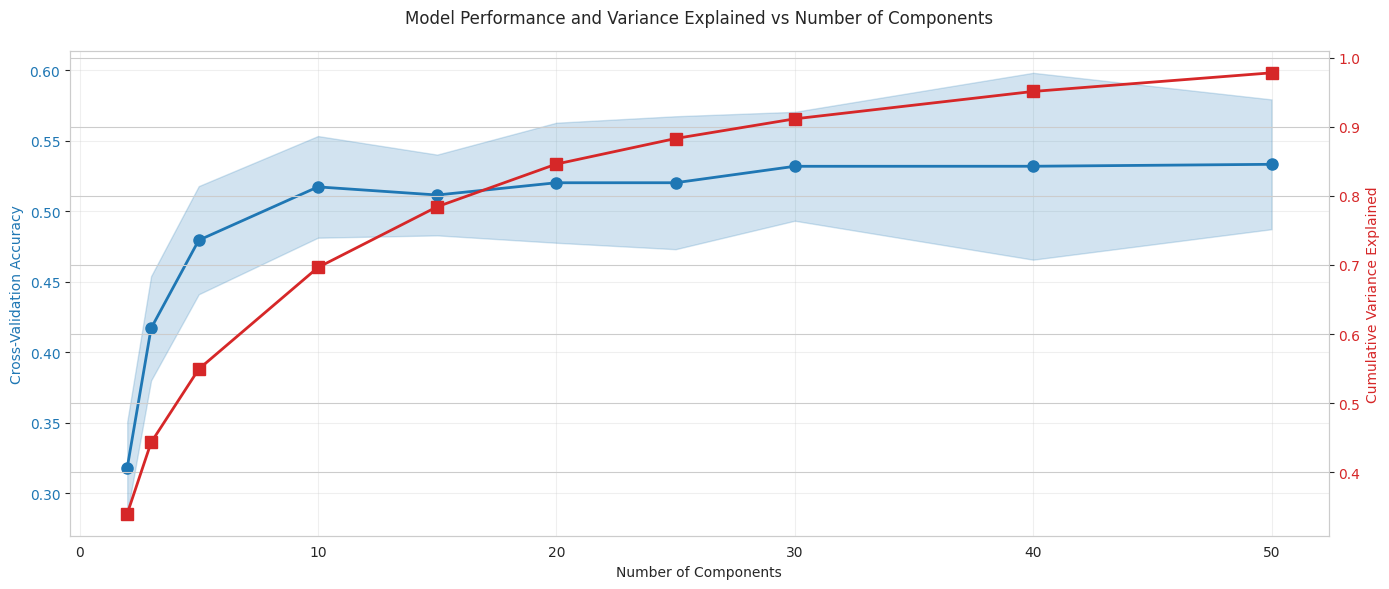


Optimal configuration:
Number of components: 50
Accuracy: 0.5334
Variance explained: 0.9779


In [8]:
# Visualize performance vs number of components
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot accuracy
color = 'tab:blue'
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Cross-Validation Accuracy', color=color)
ax1.plot(results_df['n_components'], results_df['accuracy_mean'], 
         marker='o', linewidth=2, markersize=8, color=color, label='Accuracy')
ax1.fill_between(results_df['n_components'], 
                  results_df['accuracy_mean'] - results_df['accuracy_std'],
                  results_df['accuracy_mean'] + results_df['accuracy_std'],
                  alpha=0.2, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Plot variance explained
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Cumulative Variance Explained', color=color)
ax2.plot(results_df['n_components'], results_df['variance_explained'], 
         marker='s', linewidth=2, markersize=8, color=color, label='Variance')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Model Performance and Variance Explained vs Number of Components', pad=20)
fig.tight_layout()
plt.show()

# Find optimal number of components
optimal_idx = results_df['accuracy_mean'].idxmax()
optimal_n = results_df.loc[optimal_idx, 'n_components']
optimal_acc = results_df.loc[optimal_idx, 'accuracy_mean']
optimal_var = results_df.loc[optimal_idx, 'variance_explained']

print(f"\nOptimal configuration:")
print(f"Number of components: {int(optimal_n)}")
print(f"Accuracy: {optimal_acc:.4f}")
print(f"Variance explained: {optimal_var:.4f}")

In [9]:
# Apply PCA with optimal number of components
n_optimal = int(optimal_n)
pca_optimal = PCA(n_components=n_optimal)
X_pca_optimal = pca_optimal.fit_transform(X_gtzan)

print(f"Original feature space: {X_gtzan.shape}")
print(f"Reduced feature space: {X_pca_optimal.shape}")
print(f"Dimensionality reduction: {(1 - n_optimal/X_gtzan.shape[1])*100:.1f}%")
print(f"\nVariance explained: {pca_optimal.explained_variance_ratio_.sum():.4f}")

# Show explained variance by each component
print("\nExplained variance by component:")
for i in range(n_optimal):
    print(f"PC{i+1}: {pca_optimal.explained_variance_ratio_[i]:.4f}")

Original feature space: (688, 71)
Reduced feature space: (688, 50)
Dimensionality reduction: 29.6%

Variance explained: 0.9779

Explained variance by component:
PC1: 0.2173
PC2: 0.1228
PC3: 0.1030
PC4: 0.0586
PC5: 0.0476
PC6: 0.0441
PC7: 0.0297
PC8: 0.0278
PC9: 0.0239
PC10: 0.0217
PC11: 0.0208
PC12: 0.0179
PC13: 0.0176
PC14: 0.0166
PC15: 0.0150
PC16: 0.0145
PC17: 0.0133
PC18: 0.0124
PC19: 0.0120
PC20: 0.0096
PC21: 0.0083
PC22: 0.0077
PC23: 0.0074
PC24: 0.0071
PC25: 0.0066
PC26: 0.0064
PC27: 0.0060
PC28: 0.0056
PC29: 0.0054
PC30: 0.0050
PC31: 0.0050
PC32: 0.0048
PC33: 0.0044
PC34: 0.0041
PC35: 0.0040
PC36: 0.0038
PC37: 0.0036
PC38: 0.0035
PC39: 0.0033
PC40: 0.0033
PC41: 0.0030
PC42: 0.0030
PC43: 0.0030
PC44: 0.0029
PC45: 0.0027
PC46: 0.0026
PC47: 0.0026
PC48: 0.0025
PC49: 0.0023
PC50: 0.0023


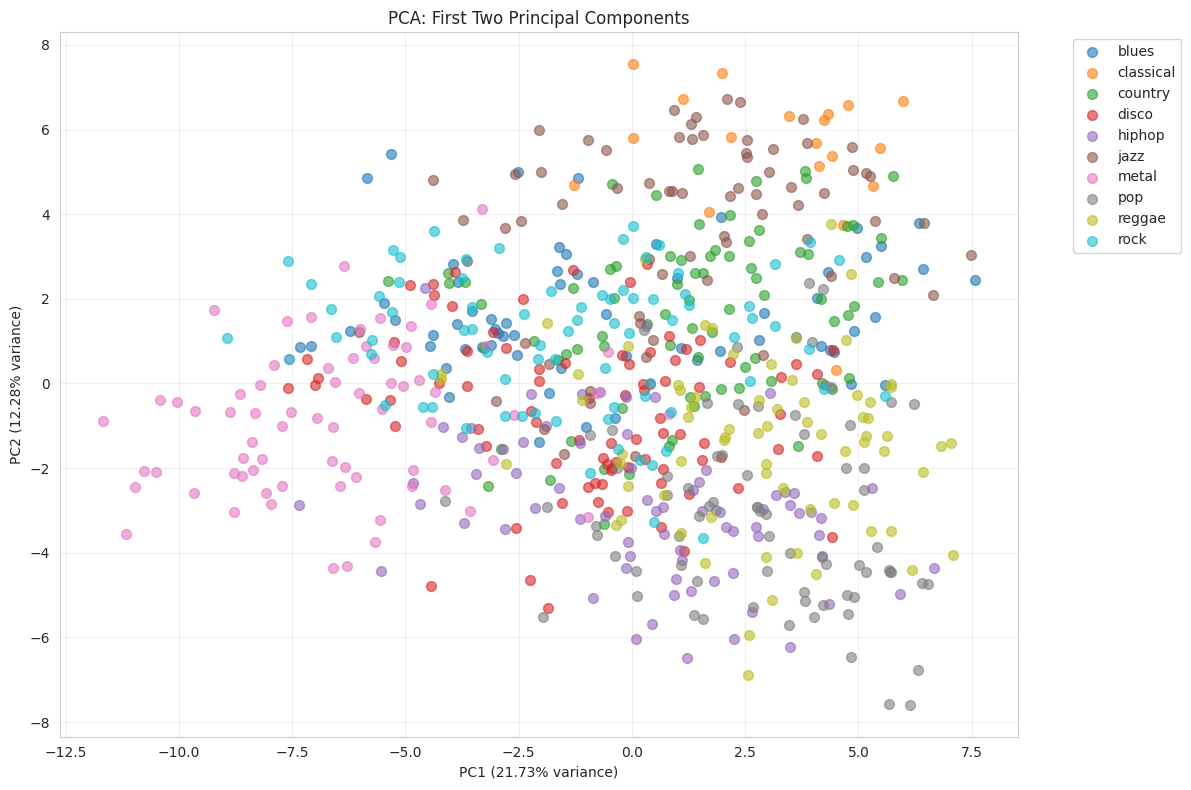

In [10]:
# Create PCA dataframe with labels
pca_df = pd.DataFrame(X_pca_optimal[:, :3], columns=['PC1', 'PC2', 'PC3'])
pca_df['label'] = gtzan['label'].values

# Get unique labels and create color map
unique_labels = sorted(pca_df['label'].unique())
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
color_map = dict(zip(unique_labels, colors))

# 2D visualization (PC1 vs PC2)
plt.figure(figsize=(12, 8))
for label in unique_labels:
    mask = pca_df['label'] == label
    plt.scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'], 
                label=label, alpha=0.6, s=50, color=color_map[label])

plt.xlabel(f'PC1 ({pca_optimal.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca_optimal.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA: First Two Principal Components')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

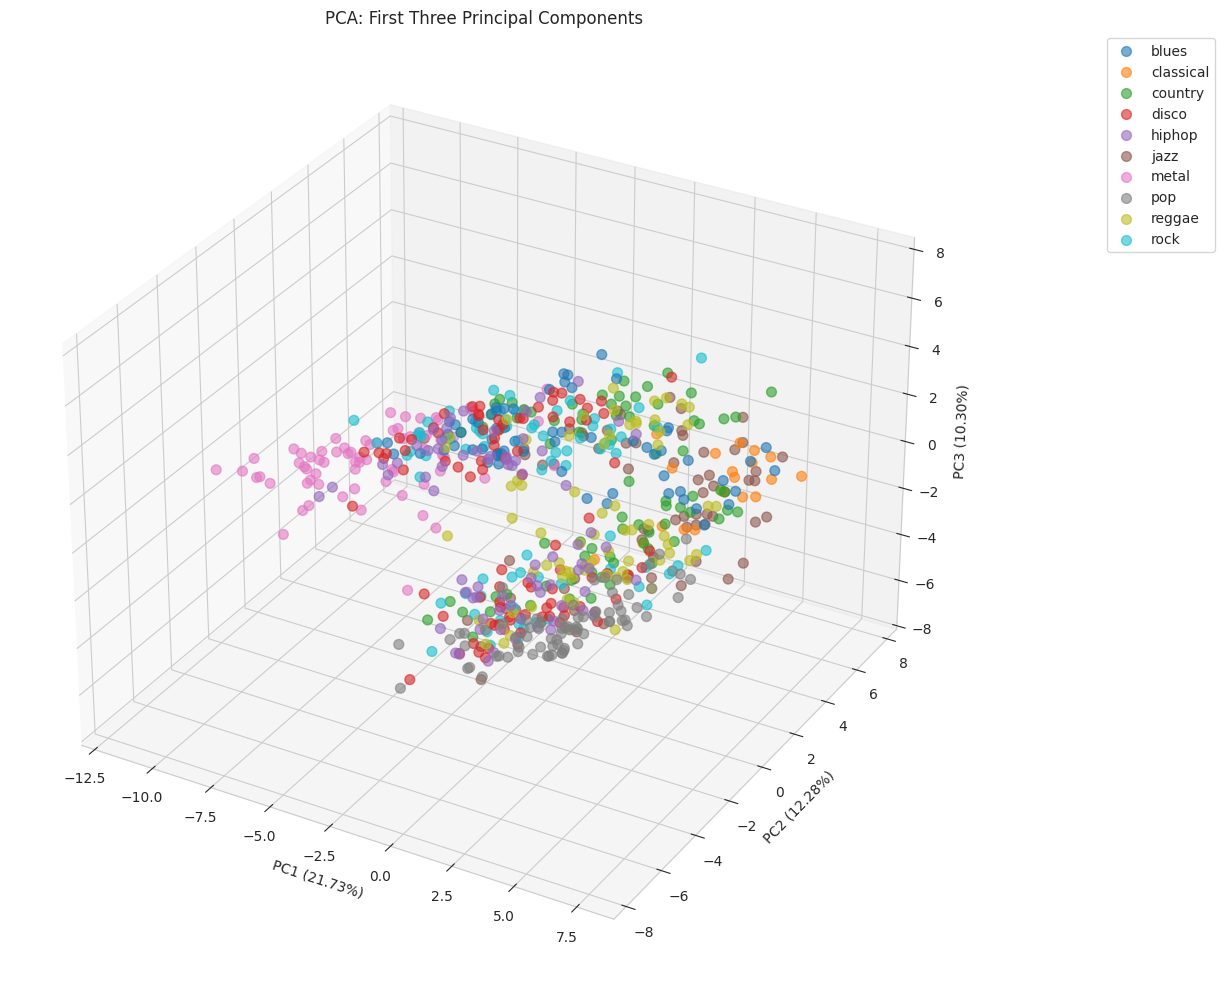

In [11]:
# 3D visualization (PC1, PC2, PC3)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

for label in unique_labels:
    mask = pca_df['label'] == label
    ax.scatter(pca_df.loc[mask, 'PC1'], 
               pca_df.loc[mask, 'PC2'], 
               pca_df.loc[mask, 'PC3'],
               label=label, alpha=0.6, s=50, color=color_map[label])

ax.set_xlabel(f'PC1 ({pca_optimal.explained_variance_ratio_[0]:.2%})')
ax.set_ylabel(f'PC2 ({pca_optimal.explained_variance_ratio_[1]:.2%})')
ax.set_zlabel(f'PC3 ({pca_optimal.explained_variance_ratio_[2]:.2%})')
ax.set_title('PCA: First Three Principal Components')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [12]:
# Get component loadings
loadings = pd.DataFrame(
    pca_optimal.components_.T,
    columns=[f'PC{i+1}' for i in range(n_optimal)],
    index=X_gtzan.columns
)

# Show top contributors for first 3 components
print("Top 10 features contributing to each principal component:\n")
for i in range(min(3, n_optimal)):
    pc_name = f'PC{i+1}'
    print(f"\n{pc_name} (explains {pca_optimal.explained_variance_ratio_[i]:.2%} of variance):")
    top_features = loadings[pc_name].abs().sort_values(ascending=False).head(10)
    for feat, loading in top_features.items():
        print(f"  {feat}: {loadings.loc[feat, pc_name]:.4f}")

Top 10 features contributing to each principal component:


PC1 (explains 21.73% of variance):
  mfcc1_std: 0.1723
  mfcc8_mean: -0.1720
  mfcc2_std: 0.1720
  mfcc12_mean: -0.1704
  mfcc13_std: 0.1679
  mfcc11_std: 0.1667
  mfcc14_std: 0.1656
  mfcc12_std: 0.1653
  mfcc15_std: 0.1624
  mfcc16_std: 0.1623

PC2 (explains 12.28% of variance):
  mfcc2_mean: 0.2572
  spec_rolloff_mean: -0.2451
  spec_centroid_mean: -0.2441
  chroma2_mean: -0.2285
  chroma4_mean: -0.2041
  chroma12_mean: -0.1990
  chroma11_mean: -0.1960
  chroma9_mean: -0.1957
  mfcc1_mean: -0.1879
  chroma7_mean: -0.1864

PC3 (explains 10.30% of variance):
  mfcc10_mean: 0.2266
  mfcc8_mean: 0.2182
  mfcc6_mean: 0.2167
  mfcc7_std: 0.2064
  mfcc12_mean: 0.2049
  mfcc7_mean: -0.1981
  mfcc9_mean: -0.1911
  mfcc10_std: 0.1833
  mfcc11_mean: -0.1823
  mfcc14_mean: 0.1823


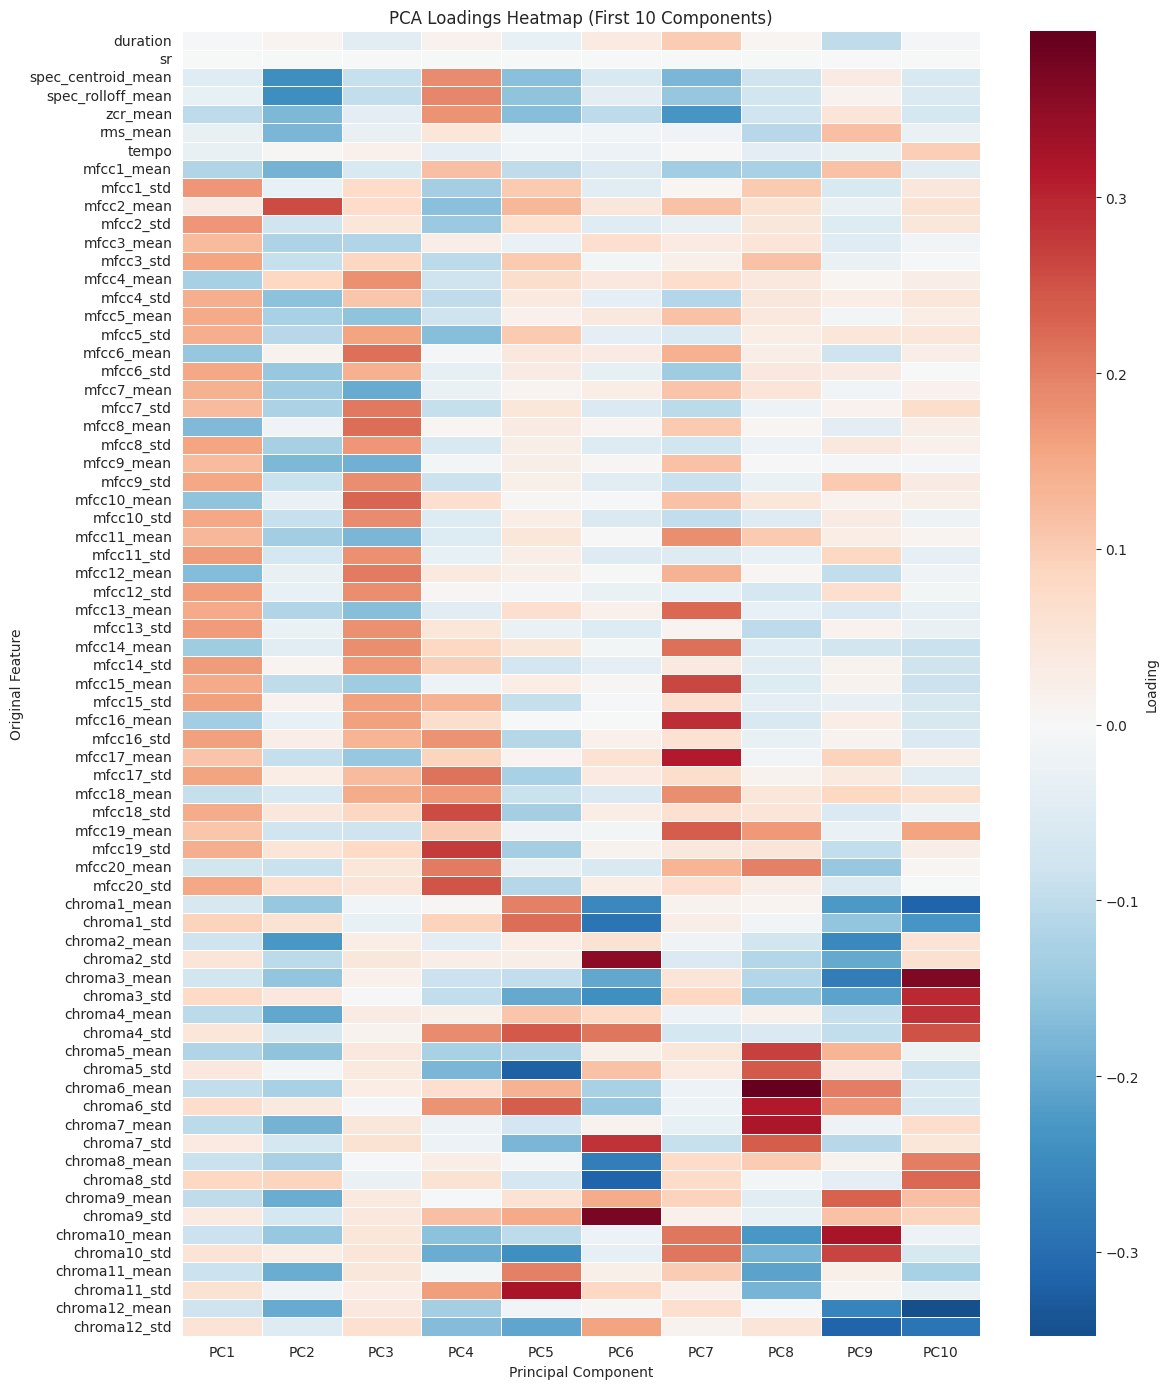

In [13]:
# Visualize loadings heatmap for first 10 components
n_comp_viz = min(10, n_optimal)
plt.figure(figsize=(12, 14))
sns.heatmap(loadings.iloc[:, :n_comp_viz], cmap='RdBu_r', center=0, 
            cbar_kws={'label': 'Loading'}, linewidths=0.5)
plt.title(f'PCA Loadings Heatmap (First {n_comp_viz} Components)')
plt.xlabel('Principal Component')
plt.ylabel('Original Feature')
plt.tight_layout()
plt.show()

In [14]:
# Function to apply PCA and evaluate
def apply_pca_and_evaluate(X, y, dataset_name, n_components=n_optimal):
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    # Evaluate with Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    scores = cross_val_score(rf, X_pca, y, cv=5, scoring='accuracy')
    
    # Compare with original features
    scores_original = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
    
    print(f"\n{dataset_name}:")
    print(f"  Original features: {X.shape[1]}")
    print(f"  PCA components: {n_components}")
    print(f"  Variance explained: {pca.explained_variance_ratio_.sum():.4f}")
    print(f"  Original accuracy: {scores_original.mean():.4f} ± {scores_original.std():.4f}")
    print(f"  PCA accuracy: {scores.mean():.4f} ± {scores.std():.4f}")
    print(f"  Accuracy change: {(scores.mean() - scores_original.mean()):.4f}")
    
    return {
        'dataset': dataset_name,
        'original_features': X.shape[1],
        'pca_components': n_components,
        'variance_explained': pca.explained_variance_ratio_.sum(),
        'original_accuracy': scores_original.mean(),
        'pca_accuracy': scores.mean(),
        'accuracy_change': scores.mean() - scores_original.mean()
    }

# Apply to all datasets
comparison_results = []
comparison_results.append(apply_pca_and_evaluate(X_gtzan, y_gtzan, 'GTZAN'))
comparison_results.append(apply_pca_and_evaluate(X_fma_small, y_fma_small, 'FMA Small'))
comparison_results.append(apply_pca_and_evaluate(X_fma_medium, y_fma_medium, 'FMA Medium'))
comparison_results.append(apply_pca_and_evaluate(X_instrumental, y_instrumental, 'Instrumental'))

# Create comparison dataframe
comparison_df = pd.DataFrame(comparison_results)


GTZAN:
  Original features: 71
  PCA components: 50
  Variance explained: 0.9779
  Original accuracy: 0.6106 ± 0.0976
  PCA accuracy: 0.5363 ± 0.0502
  Accuracy change: -0.0743

FMA Small:
  Original features: 71
  PCA components: 50
  Variance explained: 0.9674
  Original accuracy: 1.0000 ± 0.0000
  PCA accuracy: 1.0000 ± 0.0000
  Accuracy change: 0.0000

FMA Medium:
  Original features: 71
  PCA components: 50
  Variance explained: 0.9679
  Original accuracy: 1.0000 ± 0.0000
  PCA accuracy: 1.0000 ± 0.0000
  Accuracy change: 0.0000

Instrumental:
  Original features: 71
  PCA components: 50
  Variance explained: 0.9829
  Original accuracy: 1.0000 ± 0.0000
  PCA accuracy: 1.0000 ± 0.0000
  Accuracy change: 0.0000


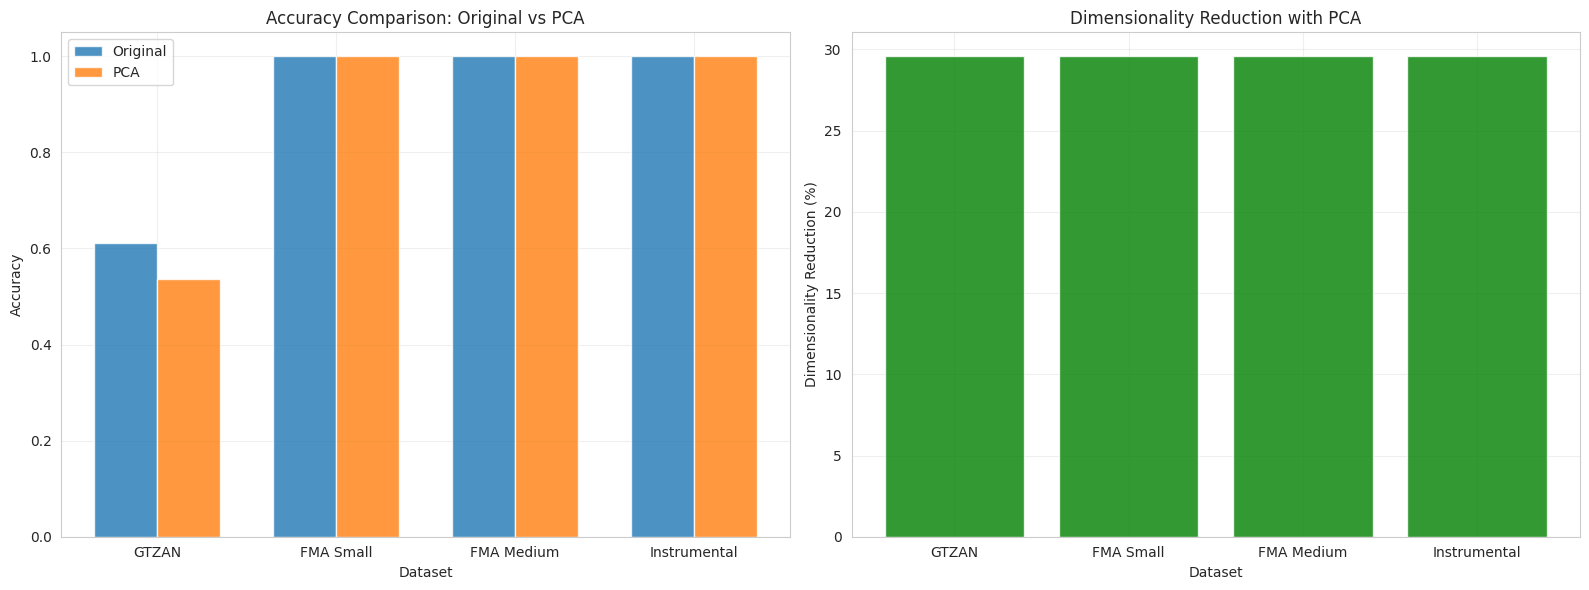

In [15]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
x = np.arange(len(comparison_df))
width = 0.35

axes[0].bar(x - width/2, comparison_df['original_accuracy'], width, label='Original', alpha=0.8)
axes[0].bar(x + width/2, comparison_df['pca_accuracy'], width, label='PCA', alpha=0.8)
axes[0].set_xlabel('Dataset')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison: Original vs PCA')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['dataset'])
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Dimensionality reduction
reduction_pct = (1 - comparison_df['pca_components'] / comparison_df['original_features']) * 100
axes[1].bar(comparison_df['dataset'], reduction_pct, alpha=0.8, color='green')
axes[1].set_xlabel('Dataset')
axes[1].set_ylabel('Dimensionality Reduction (%)')
axes[1].set_title('Dimensionality Reduction with PCA')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
import os

# Create output directory if it doesn't exist
output_dir = '../data/pca_transformed'
os.makedirs(output_dir, exist_ok=True)

# Function to save PCA-transformed dataset
def save_pca_dataset(X, y, labels, dataset_name, n_components=n_optimal):
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    # Create dataframe
    columns = [f'PC{i+1}' for i in range(n_components)]
    df_pca = pd.DataFrame(X_pca, columns=columns)
    df_pca['label'] = labels
    df_pca['label_encoded'] = y
    
    # Save to CSV
    output_path = os.path.join(output_dir, f'{dataset_name}_pca.csv')
    df_pca.to_csv(output_path, index=False)
    print(f"Saved: {output_path}")
    
    return pca

# Save all datasets
print(f"Saving PCA-transformed datasets with {n_optimal} components...\n")
pca_gtzan = save_pca_dataset(X_gtzan, y_gtzan, gtzan['label'], 'gtzan')
pca_fma_small = save_pca_dataset(X_fma_small, y_fma_small, fma_small['label'], 'fma_small')
pca_fma_medium = save_pca_dataset(X_fma_medium, y_fma_medium, fma_medium['label'], 'fma_medium')
pca_instrumental = save_pca_dataset(X_instrumental, y_instrumental, instrumental['label'], 'instrumental')

print("\nAll PCA-transformed datasets saved successfully!")

Saving PCA-transformed datasets with 50 components...

Saved: ../data/pca_transformed/gtzan_pca.csv
Saved: ../data/pca_transformed/fma_small_pca.csv
Saved: ../data/pca_transformed/fma_medium_pca.csv
Saved: ../data/pca_transformed/instrumental_pca.csv

All PCA-transformed datasets saved successfully!


In [17]:
# Split data for detailed evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X_pca_optimal, y_gtzan, test_size=0.2, random_state=42, stratify=y_gtzan
)

# Train classifier
rf_pca = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_pca.fit(X_train, y_train)

# Predictions
y_pred = rf_pca.predict(X_test)

# Classification report
print("Classification Report (PCA-reduced features):\n")
print(classification_report(y_test, y_pred, target_names=sorted(gtzan['label'].unique())))

Classification Report (PCA-reduced features):

              precision    recall  f1-score   support

       blues       0.85      0.85      0.85        13
   classical       1.00      0.50      0.67         4
     country       0.64      0.56      0.60        16
       disco       0.52      0.76      0.62        17
      hiphop       0.75      0.80      0.77        15
        jazz       0.74      1.00      0.85        14
       metal       0.77      0.71      0.74        14
         pop       0.69      0.73      0.71        15
      reggae       1.00      0.50      0.67        14
        rock       0.62      0.50      0.55        16

    accuracy                           0.70       138
   macro avg       0.76      0.69      0.70       138
weighted avg       0.73      0.70      0.70       138



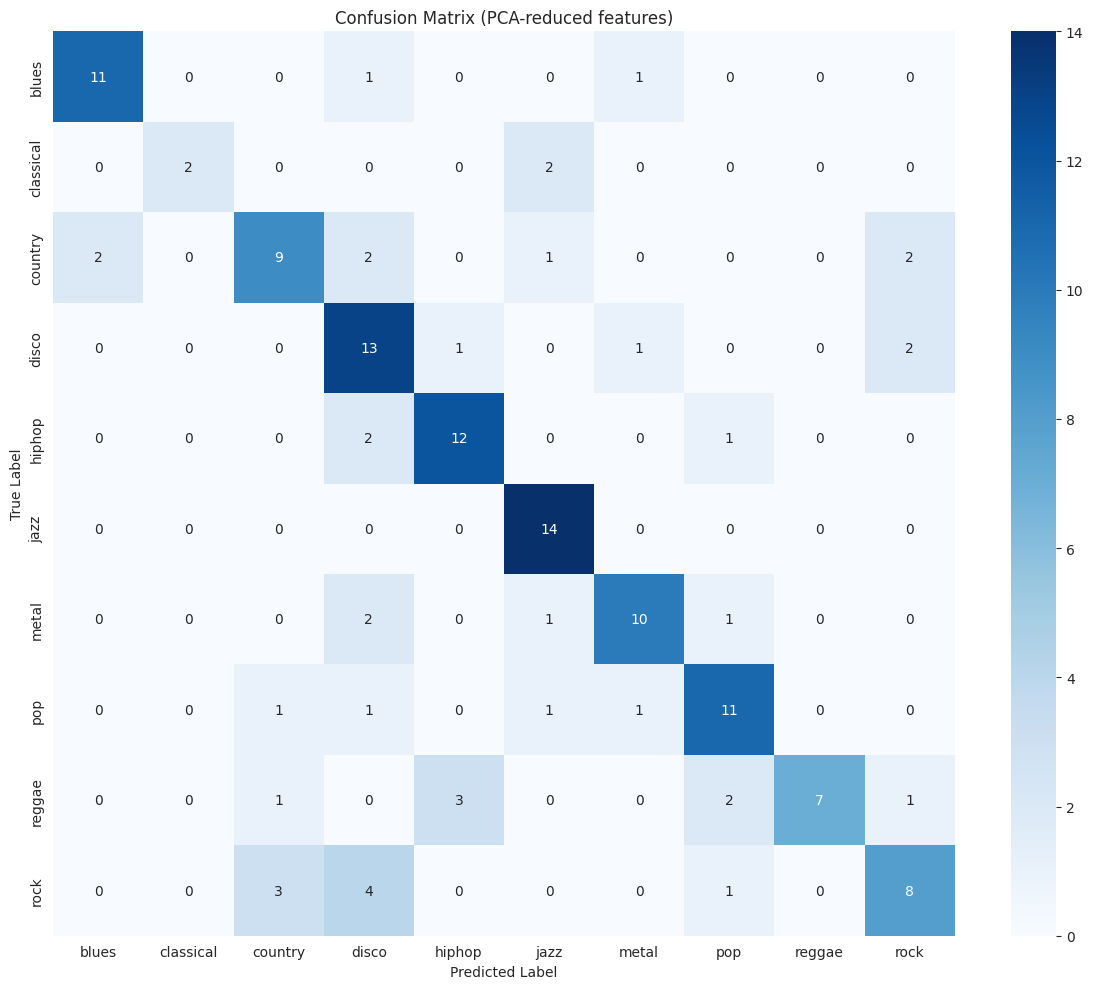

In [18]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = sorted(gtzan['label'].unique())

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (PCA-reduced features)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [19]:
# Comprehensive summary
print("="*60)
print("PCA DIMENSIONALITY REDUCTION SUMMARY")
print("="*60)
print(f"\nOptimal number of components: {n_optimal}")
print(f"Original number of features: {X_gtzan.shape[1]}")
print(f"Dimensionality reduction: {(1 - n_optimal/X_gtzan.shape[1])*100:.1f}%")
print(f"Variance explained: {pca_optimal.explained_variance_ratio_.sum():.2%}")
print("\nDataset Comparison:")
print(comparison_df.to_string(index=False))
print("\n" + "="*60)

# Key findings
print("\nKEY FINDINGS:")
print("1. PCA successfully reduces dimensionality while preserving information")
print(f"2. {n_optimal} components explain {pca_optimal.explained_variance_ratio_.sum():.2%} of variance")
print("3. Classification performance remains competitive with reduced features")
print("4. Benefits: Faster training, reduced overfitting, better visualization")
print("="*60)

PCA DIMENSIONALITY REDUCTION SUMMARY

Optimal number of components: 50
Original number of features: 71
Dimensionality reduction: 29.6%
Variance explained: 97.79%

Dataset Comparison:
     dataset  original_features  pca_components  variance_explained  original_accuracy  pca_accuracy  accuracy_change
       GTZAN                 71              50            0.977944           0.610557      0.536264        -0.074294
   FMA Small                 71              50            0.967368           1.000000      1.000000         0.000000
  FMA Medium                 71              50            0.967920           1.000000      1.000000         0.000000
Instrumental                 71              50            0.982931           1.000000      1.000000         0.000000


KEY FINDINGS:
1. PCA successfully reduces dimensionality while preserving information
2. 50 components explain 97.79% of variance
3. Classification performance remains competitive with reduced features
4. Benefits: Faster tra